In [60]:
import sys
sys.path.append('../../code')
import os
import numpy as np
import dill
import torch
from functools import partial
from scipy.stats import wasserstein_distance, spearmanr
from utils import (linear_scale_forward, log_scale_forward, UniformPrior,
                   simulator_hnn, hnn_erp_param_function, load_prerun_simulations,
                   get_dataset_psd, get_dataset_peaks, load_posterior)
from sklearn.decomposition import PCA
from hnn_core import jones_2009_model

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("white")

device = 'cpu'

net = jones_2009_model()
net.clear_connectivity()

data_path = '../../data/hnn_erp'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
zero_samples = posterior_metadata['zero_samples']

t_vec = np.linspace(0, tstop, np.round(tstop/dt).astype(int))


prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_cond, theta_cond = np.load(f'{data_path}/sbi_sims/x_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')

x_orig[:, :zero_samples] = np.repeat(x_orig[:, zero_samples], zero_samples).reshape(x_orig.shape[0], zero_samples)
x_cond[:, :zero_samples] = np.repeat(x_cond[:, zero_samples], zero_samples).reshape(x_cond.shape[0], zero_samples)

load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                    'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
             for name, posterior_dict in posterior_state_dicts.items()}




raw_waveform
pca4
pca30
peak
psd
psd_peak


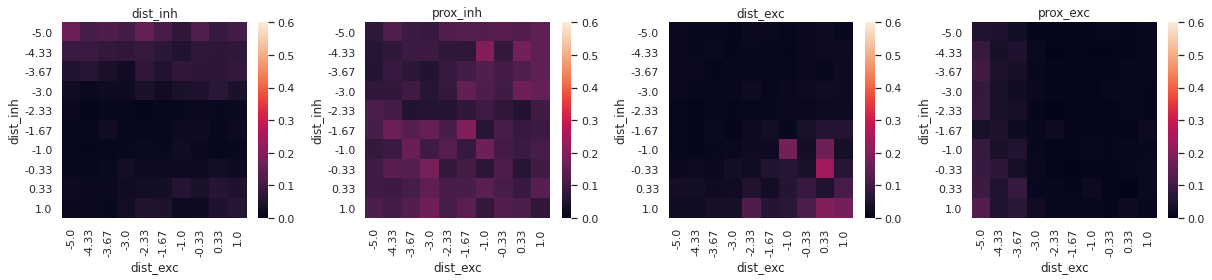

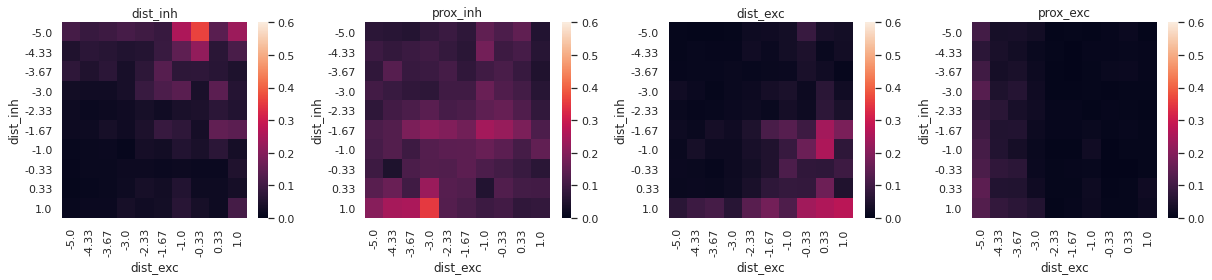

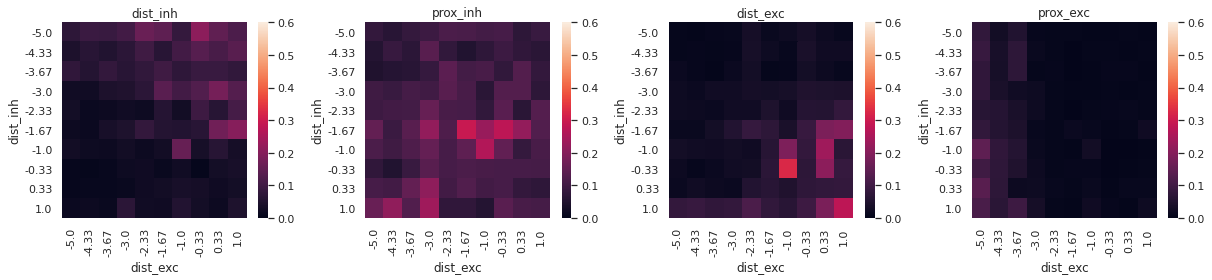

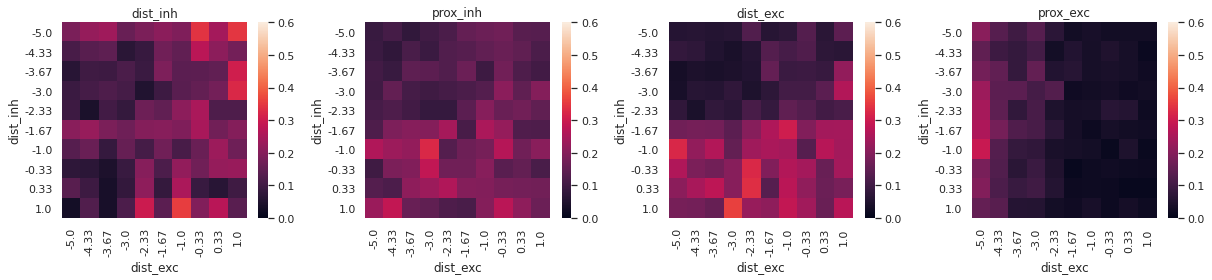

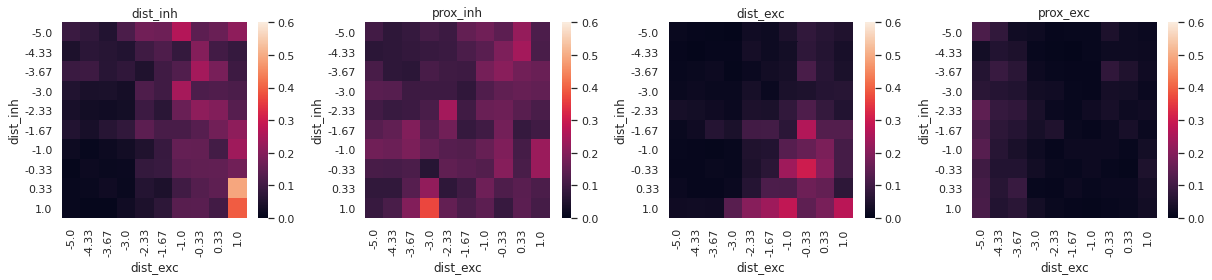

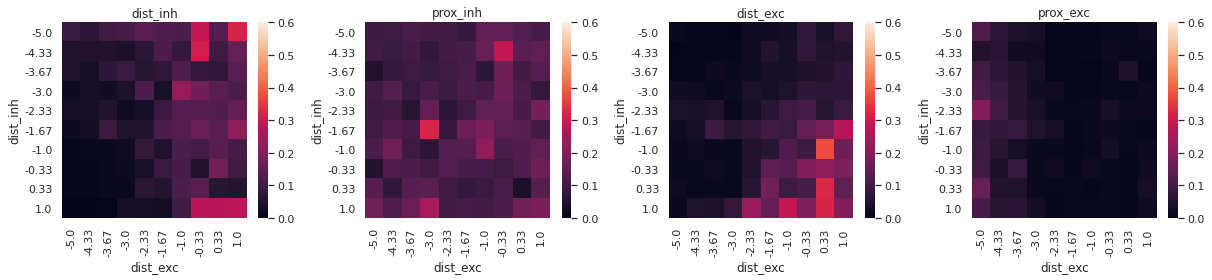

In [27]:
%matplotlib inline
plot_labels = list(prior_dict.keys())
param_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

for input_type, posterior_dict in posterior_state_dicts.items():
    print(input_type)
    
    theta_val = np.load(f'{data_path}/sbi_sims/theta_{input_type}_validation.npy')

    dist_list = list()
    for cond_idx in range(theta_cond.shape[0]):
        start_idx, stop_idx = cond_idx*10, (cond_idx+1)*10
        dist = [wasserstein_distance(theta_val[start_idx:stop_idx, param_idx], [theta_cond[cond_idx,param_idx]]) for
                param_idx in range(theta_cond.shape[1])]
        dist_list.append(dist)
    dist_array = np.array(dist_list)

    plt.figure(figsize=(17,4))
    for plot_idx in range(4):
        plt.subplot(1,4,plot_idx+1)
        xticks = np.round(np.linspace(all_bounds[3][0], all_bounds[3][1], 10), decimals=2)
        yticks = np.round(np.linspace(all_bounds[0][0], all_bounds[0][1], 10), decimals=2)
        sns.heatmap(dist_array[:,plot_idx].reshape(10,10,10,10)[:,2,5,:], vmin=0, vmax=0.6,
                    xticklabels=xticks, yticklabels=yticks)
        plt.title(plot_labels[plot_idx])
        plt.xlabel(param_labels[2])
        plt.ylabel(param_labels[0])
    plt.tight_layout()


Mean:0.00927816890180111; Std:0.006970960646867752
Mean:0.00989536102861166; Std:0.007170763332396746
Mean:0.009494945406913757; Std:0.006998039782047272
Mean:0.017188014462590218; Std:0.00867176428437233
Mean:0.01405079010874033; Std:0.010156293399631977
Mean:0.01241167914122343; Std:0.008545640856027603


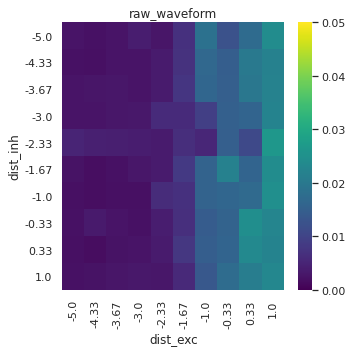

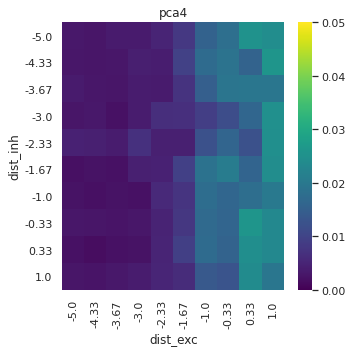

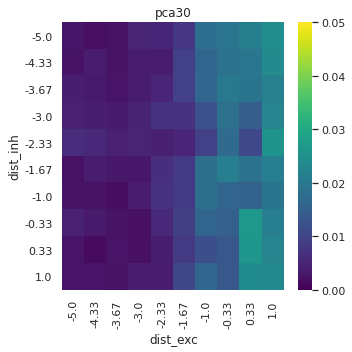

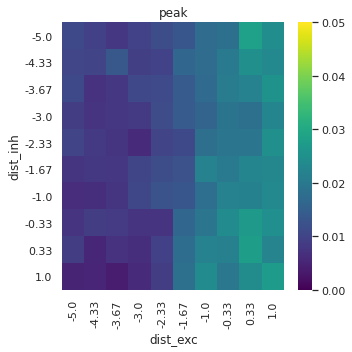

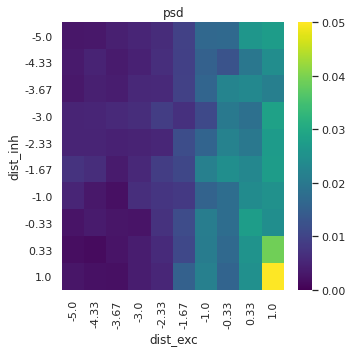

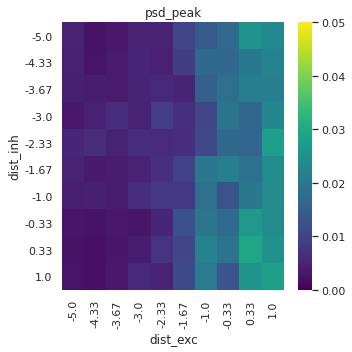

In [28]:
%matplotlib inline
plot_labels = list(prior_dict.keys())
param_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

for input_type, posterior_dict in posterior_state_dicts.items():
 

    x_val = np.load(f'{data_path}/sbi_sims/x_{input_type}_validation.npy')
    x_val[:, :zero_samples] = np.repeat(x_val[:, zero_samples], zero_samples).reshape(x_val.shape[0], zero_samples)

    theta_val = np.load(f'{data_path}/sbi_sims/theta_{input_type}_validation.npy')

    dist_list = list()
    for cond_idx in range(theta_cond.shape[0]):
        start_idx, stop_idx = cond_idx*10, (cond_idx+1)*10
        dist = np.sqrt(np.mean(np.square(x_val[start_idx:stop_idx,:] - np.tile(x_cond[cond_idx,:], 10).reshape(10,-1))))
        dist_list.append(dist)
    dist_array = np.array(dist_list)

    plt.figure(figsize=(5,5))
    xticks = np.round(np.linspace(all_bounds[3][0], all_bounds[3][1], 10), decimals=2)
    yticks = np.round(np.linspace(all_bounds[0][0], all_bounds[0][1], 10), decimals=2)
    sns.heatmap(dist_array.reshape(10,10,10,10)[:,5,5,:], vmin=0, vmax=0.05,
                xticklabels=xticks, yticklabels=yticks, cmap='viridis')
    plt.title(input_type)
    plt.xlabel(param_labels[2])
    plt.ylabel(param_labels[0])
    plt.tight_layout()
    print(f'Mean:{np.mean(dist_array)}; Std:{np.std(dist_array)}')


In [86]:
input_type_list = ['raw_waveform']
for input_type in input_type_list:
    x_val = np.load(f'{data_path}/sbi_sims/x_{input_type}_validation.npy')
    x_val[:, :zero_samples] = np.repeat(x_val[:, zero_samples], zero_samples).reshape(x_val.shape[0], zero_samples)

    theta_val = np.load(f'{data_path}/sbi_sims/theta_{input_type}_validation.npy')

    cov_list = list()
    corr_list = list()
    
    dist_list = list()
    for cond_idx in range(theta_cond.shape[0]):
        start_idx, stop_idx = cond_idx*10, (cond_idx+1)*10
        cov = np.cov(theta_val[start_idx:stop_idx,:].T)
        corr = spearmanr(theta_val[start_idx:stop_idx,:])[0]
        dist = [wasserstein_distance(theta_val[start_idx:stop_idx, param_idx], [theta_cond[cond_idx,param_idx]]) for
                param_idx in range(theta_cond.shape[1])]
        
        dist_list.append(dist)
        cov_list.append(cov)
        corr_list.append(corr)
        
        #dist_list.append(corr[0,1])
    
    dist_array = np.array(dist_list)
    
    #plt.figure(figsize=(5,5))
    #xticks = np.round(np.linspace(all_bounds[3][0], all_bounds[3][1], 10), decimals=2)
    #yticks = np.round(np.linspace(all_bounds[0][0], all_bounds[0][1], 10), decimals=2)
    #sns.heatmap(dist_array.reshape(10,10,10,10)[:,5,5,:], vmin=-1.0, vmax=1.0,
    #            xticklabels=xticks, yticklabels=yticks, cmap='viridis')
    #plt.title(input_type)
    #plt.xlabel(param_labels[2])
    #plt.ylabel(param_labels[0])
    #plt.tight_layout()
    #print(f'Mean:{np.mean(dist_array)}; Std:{np.std(dist_array)}')


In [92]:
np.argmax(dist_array, axis=0)

array([ 750, 3024, 7608, 6960])

In [93]:
for idx in [ 750, 3024, 7608, 6960]:
    print(f'np.array({theta_cond[idx]})')

np.array([0.05 0.75 0.55 0.05])
np.array([0.35 0.05 0.25 0.45])
np.array([0.75 0.65 0.05 0.85])
np.array([0.65 0.95 0.65 0.05])
